In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import os
import imageio
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale
import time

In [2]:
device = torch.device('cuda:0')
dtype = torch.float32
torch.backends.cudnn.benchmark = True

In [3]:
def read_all_image_folders(directories):
    images_075, images_300 = [], []
    for ix in directories:
        directory = f"../data/CAT_0{ix}/x1"
        for filename in os.listdir(directory):
            if filename.endswith(".jpg"):
                image = imageio.imread(f'{directory}/{filename}')
                images_300.append(scale_image(image, 0.5))        
                images_075.append(scale_image(image, 0.1))
    return images_075, images_300

In [4]:
def scale_image(image, scale):
    image = rescale(image=image, scale=scale, multichannel=True, anti_aliasing=True) 
    return image

In [5]:
learning_rate = 0.001
batch_size = 16
epochs = 511

In [6]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        
        self.generator = nn.Sequential(
            nn.Conv2d(3, 30, kernel_size = 7, stride = 1, padding = 3),
            nn.ReLU(),
            nn.ConvTranspose2d(30, 15, kernel_size = 7, stride = 5, padding = 3, output_padding = 4),
            nn.ReLU(),
            nn.ConvTranspose2d(15, 9, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(9, 3, kernel_size = 3, stride = 1, padding = 1),
            nn.Sigmoid(),
#             nn.Conv2d(3, 60, kernel_size = 11, stride = 1, padding = 5),
#             nn.ReLU(),
#             nn.ConvTranspose2d(60, 30, kernel_size = 11, stride = 2, padding = 5, output_padding = 1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(30, 15, kernel_size = 9, stride = 1, padding = 4),
#             nn.ReLU(),
#             nn.ConvTranspose2d(15, 3, kernel_size = 5, stride = 1, padding = 2),
#             nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.generator(x)
        return x

In [7]:
model = generator().cuda()

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [9]:
def train(directories, epochs, batch_size):
    
    l_start = time.time()
    
    data_075, data_300 = read_all_image_folders(directories)
    x = torch.tensor(data_075, device = device, dtype = dtype)
    y = torch.tensor(data_300, device = device, dtype = dtype)
    del data_075, data_300
    
    print(f'Data loaded (m): {round((time.time() - l_start) / 60, 2)}')
    print('----------')
    
    loss_hist = []
    psnr_hist = []
    
    start = time.time()

    for t in range(epochs):
        for batch in range(0, int(x.shape[0]/batch_size)):
            
            batch_x = x[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
            batch_y = y[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
        
            outputs = model.forward(batch_x)

            loss = criterion(outputs, batch_y)
            psnr = 10 * math.log10(1 / F.mse_loss(outputs, batch_y))
            
            del batch_x, batch_y
            torch.cuda.empty_cache()
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if t % 10 == 0:
            loss_hist.append(loss.item())
            psnr_hist.append(psnr)
            print(t, f"PSNR: {psnr}, BCE: {loss.item()}, Time (m): {round((time.time() - start) / 60, 2)}")
            if psnr > 30:
                model.cpu()
                torch.save(model, f'../data/models/x10x2_{psnr}.pt')
                model.cuda()
            
    print('----------')
    print(f'Train Time (m): {round((time.time() - start) / 60, 2)}')
    
    plt.figure(1, figsize=(14,5))
    plt.subplot(1,2,1) 
    plt.title('PSNR')
    plt.plot(psnr_hist)
    plt.subplot(1,2,2)
    plt.title('BCE')
    plt.plot(loss_hist)
    plt.show()
    
    print(f'Memory allocated before clear: {torch.cuda.memory_cached()/1000**2} MB')
    del x, y
    torch.cuda.empty_cache()
    print(f'Memory allocated after clear: {torch.cuda.memory_cached()/1000**2} MB')
    
    return psnr

/home/alex/.conda/envs/super-scaler/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Data loaded (m): 4.71
----------
0 PSNR: 20.94321090562937, BCE: 0.5501108765602112, Time (m): 0.19
10 PSNR: 23.691060480836654, BCE: 0.5403081774711609, Time (m): 2.09
20 PSNR: 23.954513110981082, BCE: 0.5395886301994324, Time (m): 4.01
30 PSNR: 24.236682337756367, BCE: 0.5388525724411011, Time (m): 5.93
40 PSNR: 24.551568821719325, BCE: 0.5380493998527527, Time (m): 7.85
50 PSNR: 24.69703121510672, BCE: 0.5377354025840759, Time (m): 9.77
60 PSNR: 24.74446495732344, BCE: 0.5375880002975464, Time (m): 11.69
70 PSNR: 24.82201882146991, BCE: 0.5374351143836975, Time (m): 13.61
80 PSNR: 24.85165631876543, BCE: 0.5373598337173462, Time (m): 15.53
90 PSNR: 24.875559873102993, BCE: 0.5373132228851318, Time (m): 17.44
100 PSNR: 24.900045429474098, BCE: 0.5372588038444519, Time (m): 19.36
110 PSNR: 24.931428707646965, BCE: 0.5371955633163452, Time (m): 21.27
120 PSNR: 24.923740298692962, BCE: 0.537208080291748, Time (m): 23.19
130 PSNR: 24.959927810607887, BCE: 0.5371357202529907, Time (m): 25

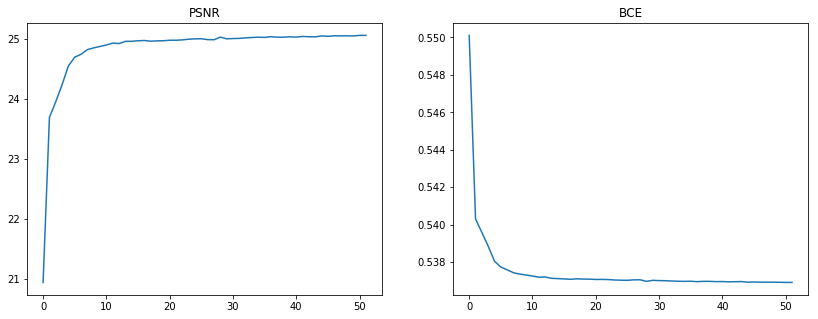

Memory allocated before clear: 2885.55008 MB
Memory allocated after clear: 5.373952 MB


In [10]:
psnr = train([0, 1, 2, 3, 4, 5, 6], epochs, batch_size)

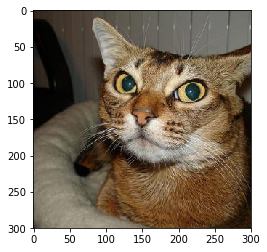

In [11]:
image = imageio.imread(f'../data/CAT_00/x1/00000001_020.jpg')
plt.imshow(image)
plt.show()

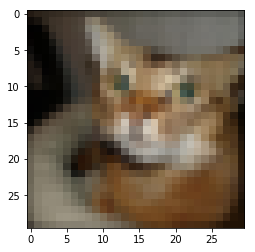

In [12]:
image_down = rescale(image=image, scale=0.1, multichannel=True, anti_aliasing=True)
plt.imshow(image_down)
plt.show()

In [13]:
image_up = model.forward(torch.tensor(image_down.reshape(1, 30, 30, 3), dtype = dtype, device = device).transpose(1, 3))

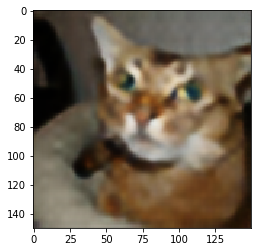

In [14]:
plt.imshow(image_up.transpose(1,3).cpu().detach().numpy().reshape(150, 150, 3))
plt.show()

In [15]:
torch.save(model.cpu(), f'../data/models/x10x2_F_{psnr}.pt')

/home/alex/.local/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
